In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [4]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [5]:
train_data.shape,test_data.shape

((210,), (60,))

In [6]:
seasonal = pd.read_csv('계절성예측.csv')
print(seasonal.shape)

(60, 1)


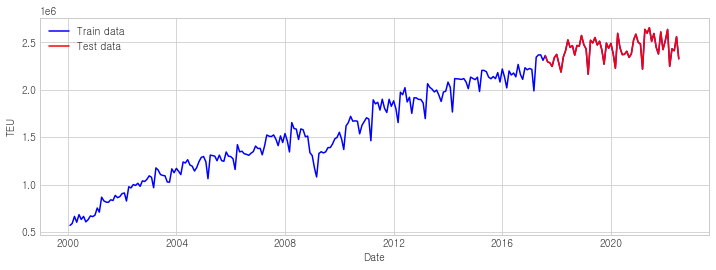

In [7]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [8]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


### 2. 다변량 LSTM

In [9]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [10]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [11]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [12]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [13]:
raw_df = data

In [14]:
split = -78
train = raw_df[0:split] 
test = raw_df[split:] 

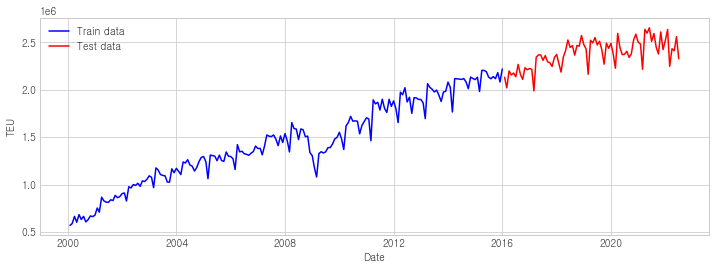

In [15]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend()

In [16]:
len(train),len(test)

(192, 78)

In [17]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [19]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [20]:
window_size = 18 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 36   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [21]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [22]:
X_train.shape,Y_train.shape

((139, 18, 10), (139, 36, 1))

### 2. X_test,Y_test 배열

In [23]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [24]:
X_test.shape,Y_test.shape

((25, 18, 10), (25, 36, 1))

In [25]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [26]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(LSTM(64,activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))
model.add(MCDropout(0.8))
model.add(Dense(1))
model.add(RepeatVector(36)) # 출력 개수만큼 반복 

## Decoder State
model.add(LSTM(64, activation='tanh', return_sequences=True)) # Decoder State 
model.add(MCDropout(0.8))
model.add(TimeDistributed(Dense(8,activation='relu'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
14/14 [==============================] - 10s 360ms/step - loss: 0.3201 - mae: 0.5230 - val_loss: 0.2187 - val_mae: 0.4152
Epoch 2/200
14/14 [==============================] - 0s 32ms/step - loss: 0.1187 - mae: 0.2767 - val_loss: 0.2291 - val_mae: 0.4382
Epoch 3/200
14/14 [==============================] - 0s 30ms/step - loss: 0.0868 - mae: 0.2413 - val_loss: 0.1315 - val_mae: 0.3193
Epoch 4/200
14/14 [==============================] - 0s 34ms/step - loss: 0.0615 - mae: 0.1968 - val_loss: 0.1701 - val_mae: 0.3804
Epoch 5/200
14/14 [==============================] - 0s 32ms/step - loss: 0.0596 - mae: 0.1936 - val_loss: 0.0998 - val_mae: 0.2725
Epoch 6/200
14/14 [==============================] - 0s 32ms/step - loss: 0.0461 - mae: 0.1670 - val_loss: 0.1118 - val_mae: 0.2825
Epoch 7/200
14/14 [==============================] - 1s 42ms/step - loss: 0.0432 - mae: 0.1606 - val_loss: 0.1017 - val_mae: 0.2680
Epoch 8/200
14/14 [==============================] - 0s 31ms/step - loss: 

In [27]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

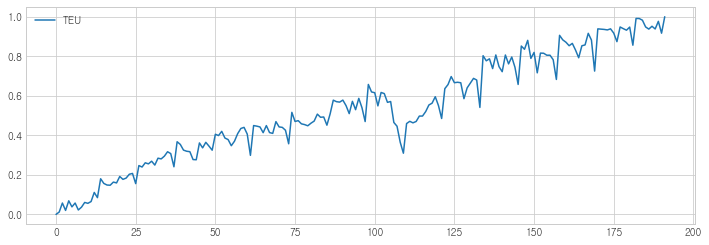

In [28]:
label_train.plot()

<AxesSubplot:>

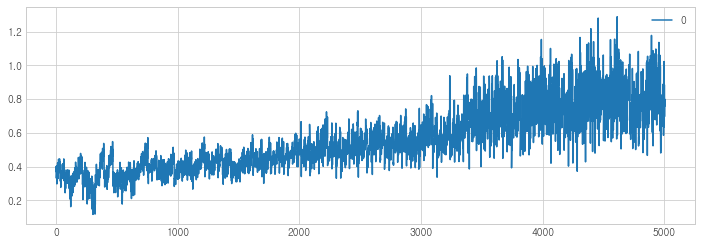

In [29]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

### 1. 2017.07 ~ 2020.06

In [30]:
X_test_1 = np.array(feature_test.head(18)).reshape((1, 18, 10)) 

In [31]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [32]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

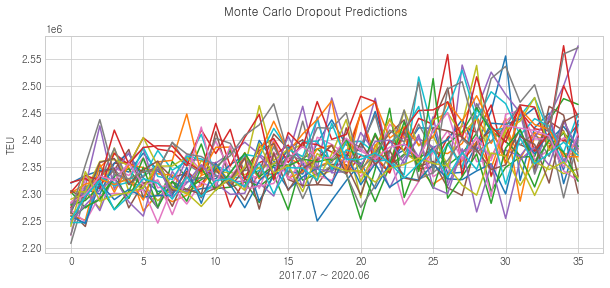

In [33]:
rcParams['figure.figsize'] = 10, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2017.07 ~ 2020.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [34]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [35]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [36]:
df.to_csv('36개월1-1.csv')

In [38]:
np.mean(df.std()/df.mean())

0.021252131089568138

In [37]:
rmse = math.sqrt(mean_squared_error(trend[0:36].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:36].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[0:36].reset_index()['TEU_Trend'])*100) )

RMSE: 51281.22916439917
MAPE: 1.7473072107024448


In [38]:
rmse = math.sqrt(mean_squared_error(trend[0:36].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:36].reset_index()['TEU_Trend']- df.transpose().median())/ trend[0:36].reset_index()['TEU_Trend'])*100) )

RMSE: 55349.678873533594
MAPE: 1.8834514978794787


In [39]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.head(36)

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2319389.0,2282826.0,2303349.25,2273877.75,2280306.25,2263373.5,2222674.5,2207758.25,2289425.5,2243580.75,2269871.5,2260004.75,2278751.5,2320509.75,2270408.5,2266002.75,2270137.75,2223948.25,2304250.75,2246267.25,2258116.25,2301046.5,2252517.0,2302189.75,2249062.0,2305333.5,2283829.0,2265398.0,2239375.0,2252155.0


In [40]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:246]
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


Mean RMSE: 109322.90211364838
Mean MAPE: 3.794416164626417


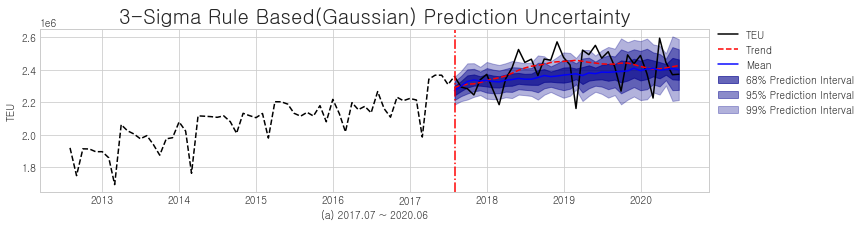

In [41]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2020.06')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:246], 'black', label='TEU')
plt.plot(trend.head(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='darkblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='darkblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df.transpose().mean())/ test_data.head(36).reset_index()['TEU'])*100) )

In [42]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.5277777777777778

In [43]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(36).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.5555555555555556

In [44]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 86793.86
Quantile 70% Interval Sharpness 81158.21006944441


Median RMSE: 111795.42316049294
Median MAPE: 3.892125300621506


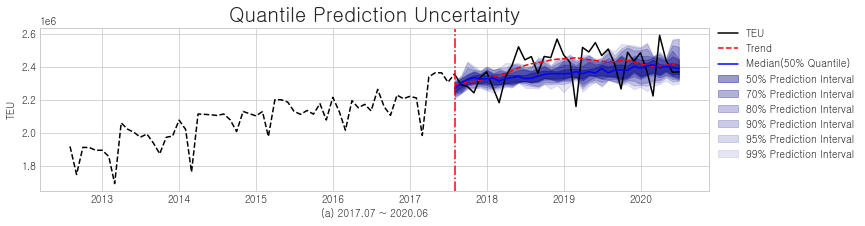

In [45]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2020.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:246], 'black', label='TEU')
plt.plot(trend.head(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='darkblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='darkblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='darkblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='darkblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='darkblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df.transpose().median()))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df.transpose().median())/ test_data.head(36).reset_index()['TEU'])*100) )

In [46]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.4722222222222222

In [47]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(36).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.5277777777777778

RMSE: 107576.16328021749
MAPE: 3.7841750907591267


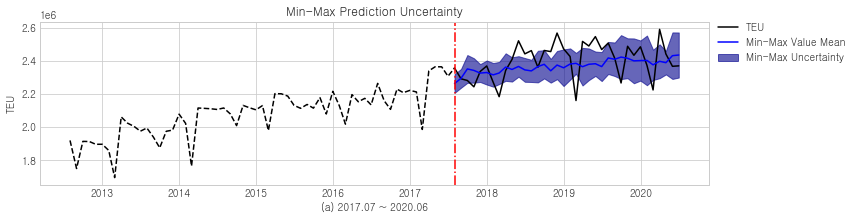

In [48]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2020.06')
plt.ylabel('TEU')
plt.title('Min-Max Prediction Uncertainty')
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:246], 'black', label='TEU')
#plt.plot(trend.head(36),color='red',label='Trend',linestyle='dashed')
plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='blue',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='darkblue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='darkblue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='darkblue',alpha=0.6, label='Min-Max Uncertainty')
plt.plot()
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.head(36).reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [49]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.5277777777777778

In [50]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 173587.64
Quantile 95% Interval Sharpness 156966.06805555563
Min Max Interval Sharpness 181985.19


In [51]:
import CRPS.CRPS as pscore

In [52]:
crps = []

for i in range(0,36):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.head(36).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

72462.34611111111
8723.085555555554
27173.360833333332
72474.66444444447
8828.99388888889
23393.93388888889
37570.82250000001
120762.19805555558
9949.649444444443
51872.02305555555
159094.7997222222
85124.14972222222
103647.58583333333
12836.453333333331
79663.70694444445
83854.68777777778
188269.78861111111
82967.96472222223
40894.41499999999
194733.49500000002
127508.545
87315.7961111111
153214.81944444444
61051.71083333333
99275.10972222223
19499.001111111113
84013.7561111111
73944.14805555556
18608.868055555555
64258.958333333336
19605.949444444446
155032.12249999997
168648.26138888887
25717.939999999995
19012.72416666667
15573.225555555557


In [53]:
a = np.array([72462.34611111111,
8723.085555555554,
27173.360833333332,
72474.66444444447,
8828.99388888889,
23393.93388888889,
37570.82250000001,
120762.19805555558,
9949.649444444443,
51872.02305555555,
159094.7997222222,
85124.14972222222,
103647.58583333333,
12836.453333333331,
79663.70694444445,
83854.68777777778,
188269.78861111111,
82967.96472222223,
40894.41499999999,
194733.49500000002,
127508.545,
87315.7961111111,
153214.81944444444,
61051.71083333333,
99275.10972222223,
19499.001111111113,
84013.7561111111,
73944.14805555556,
18608.868055555555,
64258.958333333336,
19605.949444444446,
155032.12249999997,
168648.26138888887,
25717.939999999995,
19012.72416666667,
15573.225555555557])

In [54]:
np.mean(a)

73793.86278549382

In [55]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2362737.8

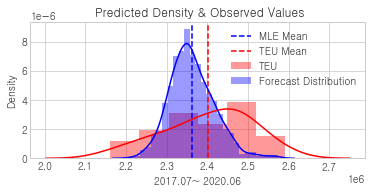

In [56]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.head(36).mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.head(36).reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2017.07~ 2020.06')
plt.legend()

In [57]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.head(36).reset_index()['TEU'].mean(), scale=test_data.head(36).reset_index()['TEU'].std() ) )
LL

13721.19896824421

In [58]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

13717.197964017832

In [59]:
LL = -np.sum( stats.norm.logpdf(test_data.head(36).reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

621.7129252237411

In [60]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [61]:
for i in range(0,30):
    print(KL(df[i],test_data.head(36).reset_index()['TEU']))

963019.8473132383
1516513.746688708
1801581.868859349
1203772.166751377
3942.3957907469594
1170253.2755029395
1243677.403619537
1149607.3807797134
1626631.7478168248
916482.5252544531
1540919.8755356038
1634774.4132050998
1889321.6386333609
178286.45244918633
1748070.4435360408
1869560.1645668207
2173938.9666755255
1660387.7274314002
665951.4719496147
535489.500605789
2480031.4108852125
330869.94793657016
1852002.5210834225
340419.0960152271
2187270.610899639
1606695.212185048
1261223.589450849
594468.448806293
2423589.24619823
2075826.240782388


In [62]:
a = np.array([963019.8473132383,
1516513.746688708,
1801581.868859349,
1203772.166751377,
3942.3957907469594,
1170253.2755029395,
1243677.403619537,
1149607.3807797134,
1626631.7478168248,
916482.5252544531,
1540919.8755356038,
1634774.4132050998,
1889321.6386333609,
178286.45244918633,
1748070.4435360408,
1869560.1645668207,
2173938.9666755255,
1660387.7274314002,
665951.4719496147,
535489.500605789,
2480031.4108852125,
330869.94793657016,
1852002.5210834225,
340419.0960152271,
2187270.610899639,
1606695.212185048,
1261223.589450849,
594468.448806293,
2423589.24619823,
2075826.240782388])

In [63]:
np.mean(a)

1354819.3112402738

In [39]:
df.to_csv('LSTM.csv')

### 2. 2019.07 ~ 2022.06

In [37]:
X_test_2 = np.array(feature_test[24:42]).reshape((1, 18, 10)) 

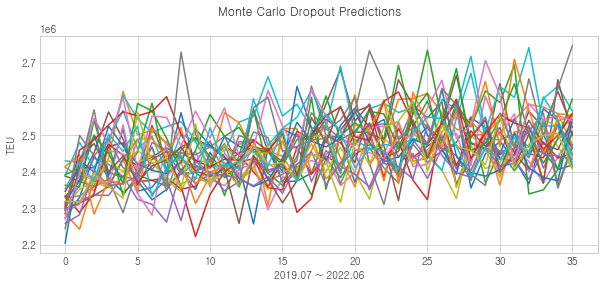

In [38]:
model_MC=  model
prediction = [model_MC.predict(X_test_2) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 10, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2019.07 ~ 2022.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [39]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [40]:
np.mean(df.std()/df.mean())

0.03015216812491417

In [41]:
df.to_csv('36개월2-1.csv')

In [68]:
rmse = math.sqrt(mean_squared_error(trend.tail(36).reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.tail(36).reset_index()['TEU_Trend']- df.transpose().mean())/ trend.tail(36).reset_index()['TEU_Trend'])*100) )

RMSE: 26978.848148778095
MAPE: 0.7727388960688351


In [69]:
rmse = math.sqrt(mean_squared_error(trend.tail(36).reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.tail(36).reset_index()['TEU_Trend']- df.transpose().median())/ trend.tail(36).reset_index()['TEU_Trend'])*100) )

RMSE: 30366.8380591023
MAPE: 0.8686826697250454


In [70]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.tail(36)

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-31,2273800.0,2413055.0,2332507.0,2346066.25,2301147.75,2388713.25,2308037.0,2328643.5,2311438.75,2430391.5,2316882.0,2285850.75,2363730.25,2334180.0,2312570.0,2298348.0,2294725.0,2244189.5,2303590.5,2389423.5,2203999.75,2414655.5,2392200.75,2303418.75,2258878.75,2294329.5,2270888.75,2284275.5,2320203.75,2353580.0


In [71]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
#data = data.iloc[:246]
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


Mean RMSE: 116868.33237502704
Mean MAPE: 3.930571986541484


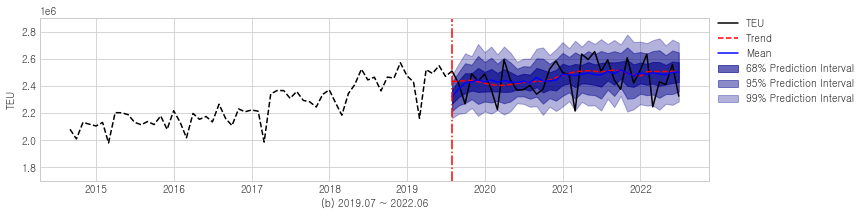

In [72]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2019.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[175:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:], 'black', label='TEU')
plt.plot(trend.tail(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='darkblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='darkblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df.transpose().mean())/ test_data.tail(36).reset_index()['TEU'])*100) )

In [73]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(36).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75


In [74]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(36).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

추세 변동에 대한 포함확률: 0.9722222222222222


In [75]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 147124.61
Quantile 70% Interval Sharpness 140241.87465277786


Median RMSE: 117510.16018252008
Median MAPE: 3.8987176197513143


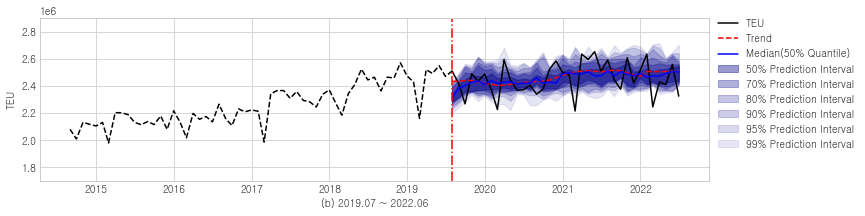

In [76]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2019.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[175:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:], 'black', label='TEU')
plt.plot(trend.tail(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue')
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='darkblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='darkblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='darkblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='darkblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='darkblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df.transpose().median()))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df.transpose().median())/ test_data.tail(36).reset_index()['TEU'])*100) )

In [77]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(36).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.75

In [78]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(36).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.9722222222222222

RMSE: 133829.3562704078
MAPE: 4.350209239420248


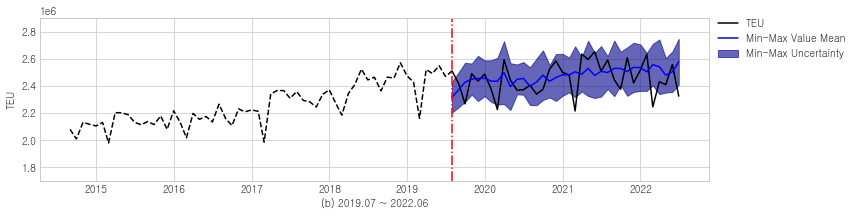

In [79]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2019.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Min-Max Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[175:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:], 'black', label='TEU')
plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='blue',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='darkblue',alpha=0.6, label='Min-Max Uncertainty')
plt.plot()
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.head(36).reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [80]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(36).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.75

In [81]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 294249.4
Quantile 95% Interval Sharpness 257174.71996527765
Min Max Interval Sharpness 311616.88


In [82]:
crps = []

for i in range(0,36):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.tail(36).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

158082.34777777776
22263.206388888884
111982.37444444442
36678.13416666666
20100.50083333333
40668.470277777786
41708.587777777786
164294.39666666673
119984.20583333336
17699.378055555564
30736.518055555553
37453.646666666675
14647.889444444445
91170.73472222225
30752.33611111111
53028.98
104425.02277777778
16482.69972222222
17493.22555555556
214932.11722222227
110068.88916666666
66061.95250000001
127668.815
25988.105555555554
49059.1463888889
21943.614166666663
105635.45833333336
68687.44972222223
29696.416111111106
18949.706666666672
106584.45333333335
209494.38083333336
30669.379722222217
46447.6463888889
33657.16444444444
139800.5222222222


In [83]:
a = np.array([158082.34777777776,
22263.206388888884,
111982.37444444442,
36678.13416666666,
20100.50083333333,
40668.470277777786,
41708.587777777786,
164294.39666666673,
119984.20583333336,
17699.378055555564,
30736.518055555553,
37453.646666666675,
14647.889444444445,
91170.73472222225,
30752.33611111111,
53028.98,
104425.02277777778,
16482.69972222222,
17493.22555555556,
214932.11722222227,
110068.88916666666,
66061.95250000001,
127668.815,
25988.105555555554,
49059.1463888889,
21943.614166666663,
105635.45833333336,
68687.44972222223,
29696.416111111106,
18949.706666666672,
106584.45333333335,
209494.38083333336,
30669.379722222217,
46447.6463888889,
33657.16444444444,
139800.5222222222])

In [84]:
np.mean(a)

70416.60758487655

In [85]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2459512.8

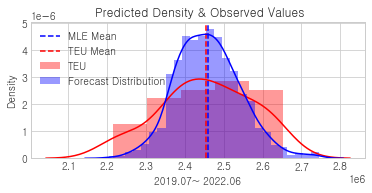

In [86]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.tail(36).mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.tail(36).reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2019.07~ 2022.06')
plt.legend()

In [87]:
LL = -np.sum( stats.norm.logpdf(df, loc=test_data.tail(36).reset_index()['TEU'].mean(), scale=test_data.tail(36).reset_index()['TEU'].std() ) )
LL

13875.94220432933

In [94]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

14748.862447482335

In [89]:
LL = -np.sum( stats.norm.logpdf(test_data.tail(36).reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

566.6264727725985

In [90]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [91]:
for i in range(0,30):
    print(KL(df[i],test_data.tail(36).reset_index()['TEU']))

1321900.2740869618
1557843.0256167979
948741.4074842681
713024.0281278545
82999.00897746332
2128023.8051528735
877843.9904340366
838958.5760021799
1079820.206792633
3103301.28799328
801085.165287798
557603.2442066919
1167380.8329137475
1143178.200010661
1629680.5373605252
378613.8446247911
117414.27874015344
439170.374339225
363928.3848083178
2147289.905697365
190525.2103804195
1246795.565501593
2207392.4789075544
1998896.5483354118
1844687.575553858
48467.17786823996
2534709.4621511353
2097862.9554195367
372382.73902962456
343175.1439312264


In [92]:
a = np.array([1321900.2740869618,
1557843.0256167979,
948741.4074842681,
713024.0281278545,
82999.00897746332,
2128023.8051528735,
877843.9904340366,
838958.5760021799,
1079820.206792633,
3103301.28799328,
801085.165287798,
557603.2442066919,
1167380.8329137475,
1143178.200010661,
1629680.5373605252,
378613.8446247911,
117414.27874015344,
439170.374339225,
363928.3848083178,
2147289.905697365,
190525.2103804195,
1246795.565501593,
2207392.4789075544,
1998896.5483354118,
1844687.575553858,
48467.17786823996,
2534709.4621511353,
2097862.9554195367,
372382.73902962456,
343175.1439312264])

In [93]:
np.mean(a)

1142756.507857874